In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm
from torch.utils.data import DataLoader,TensorDataset
from torchviz import make_dot
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = ',device)



device =  cuda


In [2]:
def create_features(ppg_data, segment_length = 625):
    num_segments = int(len(ppg_data) / segment_length)
    features = []
    for i in range(num_segments):
        segment = ppg_data[i*segment_length : (i+1)*segment_length]
        features.append(segment.values.flatten())
    return np.array(features)

# Load data
# 读取文件列表
ppg_files = glob.glob('data/PPG_data/*.csv')
bp_files = glob.glob('data/BP_data/*.csv')

X_list = []
y_list = []
y_scalers = []

i = 0
for ppg_file, bp_file in tqdm(zip(ppg_files, bp_files), total = len(ppg_files)):
    # if i < 1000: # 限制数据数量
        ppg_data = pd.read_csv(ppg_file)
        bp_data = pd.read_csv(bp_file)
        # print(ppg_data.shape)
        # print(bp_data.shape)
        
        #ppg提取特征并分段
        ppg_segments = create_features(ppg_data['PPG']) # (num_segments, 625)
        # print(ppg_segments.shape)

        #裁剪BP数据
        y_sbp = bp_data['SBP'][:len(ppg_segments)]
        # has_nan = np.isnan(y_sbp).any()
        # if ((has_nan) == True):
        #     print(f'文件{ppg_file}存在NaN值,跳过')
        y_dbp = bp_data['DBP'][:len(ppg_segments)]
        # print(y_sbp.shape, y_dbp.shape)

        #调整数据形状
        X = ppg_segments.reshape(-1, 1, 625)
        y = np.column_stack((y_sbp, y_dbp))
        
        #添加到列表
        X_list.extend(X)
        y_list.extend(y)
        i+=1

X = np.array(X_list)
y = np.array(y_list)


print(X.shape)
print(y.shape)


100%|██████████| 8997/8997 [03:20<00:00, 44.86it/s]


(394798, 1, 625)
(394798, 2)


In [3]:
class GRUBPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUBPModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 定义 CNN 层
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=50, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(in_channels=50, out_channels=50, kernel_size=7, padding=3)
        self.conv3 = nn.Conv1d(in_channels=50, out_channels=50, kernel_size=7, padding=3)

        self.bn1 = nn.BatchNorm1d(50)
        self.bn2 = nn.BatchNorm1d(50)
        self.bn3 = nn.BatchNorm1d(50)

        # Dropout 层
        self.dropout = nn.Dropout(0.5)

        # GRU 层前的 Batch Normalization
        self.gru_bn = nn.BatchNorm1d(input_size)

        # GRU 层后的 Batch Normalization
        self.gru_out_bn = nn.BatchNorm1d(hidden_size)
        
        # 定义 GRU 层
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        # 定义全连接层
        self.fc1 = nn.Linear(625 * hidden_size, 64)
        self.fc1_bn = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, output_size)
        
    def forward(self, x):
        
        # 通过CNN层
        conv1_out = self.conv1(x)
        conv1_out = torch.relu(self.bn1(conv1_out))
                                 
        conv2_out = self.conv2(conv1_out)
        conv2_out = torch.relu(self.bn2(conv2_out))

        conv3_out = self.conv3(conv2_out)
        conv3_out = torch.relu(self.bn3(conv3_out))

        # lstm_input = conv1_out + conv3_out
        x = torch.cat((conv1_out, conv3_out), dim=1) #(batch_size, 100, 625)
        x= torch.transpose(x, 1, 2) # (batch_size, 625, 100)

        # 在 LSTM 之前进行 Batch Normalization
        x = x.transpose(1, 2)
        x = self.gru_bn(x)# input (batch_size, 100, 625)
        x = x.transpose(1, 2)
        
        
        # 初始化 GRU 的隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 通过GRU层
        out, _ = self.gru(x, (h0))# input(batch_size, seq_len, input_size)

        # 在 GRU之后进行 Batch Normalization
        out = out.transpose(1, 2)
        out = self.gru_out_bn(out)
        out = out.transpose(1, 2)
        
        # 展平操作
        out = out.contiguous().view(out.size(0), -1) # [batch_size, seq_len * hidden_size]

        # 通过全连接层
        out = self.fc1(out)
        out = torch.relu(self.fc1_bn(out))
        out = self.fc2(out)
        # out = torch.relu(out)

        return out

input_size = 100
hidden_size = 25
num_layers = 1
output_size = 2

model = GRUBPModel(input_size, hidden_size, num_layers, output_size).to(device)

# 损失函数和优化器
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr = 1e-3,weight_decay=0.01)
num_epochs = 30
batch_size = 256
# summary(model, input_size=(1, 625), batch_size=402)


In [4]:
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X, y, train_size=0.8,random_state=5)
# 手动划分前20%为验证集
# num_samples = len(X)
# val_size = int(num_samples * 0.2)
# X_val_np = X[:val_size]
# y_val_np = y[:val_size]
# X_train_np = X[val_size:]
# y_train_np = y[val_size:]

scaler_X = StandardScaler()
scaler_y = StandardScaler()


X_train_np = scaler_X.fit_transform(X_train_np.reshape(-1, 625)).reshape(-1, 625, 1)
X_train_np = X_train_np.transpose(0, 2, 1)
X_val_np = scaler_X.transform(X_val_np.reshape(-1, 625)).reshape(-1, 625, 1)
X_val_np = X_val_np.transpose(0, 2, 1)

y_train_np = scaler_y.fit_transform(y_train_np)
y_val_np = scaler_y.transform(y_val_np)


X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val_np, dtype=torch.float32).to(device)

print("训练集大小: ", X_train.shape, y_train.shape)
print("验证集大小: ", X_val.shape, y_val.shape)

# 使用dataloader加载数据
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

训练集大小:  torch.Size([315838, 1, 625]) torch.Size([315838, 2])
验证集大小:  torch.Size([78960, 1, 625]) torch.Size([78960, 2])


In [5]:
# 训练和评估函数
def train(model, train_loader, val_loader, scaler_y, criterion, optimizer, epochs):
    train_loss_list = []
    val_loss_list = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        #progress_bar = tqdm(train_loader, total = len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", position = 0, leave=False) 
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs.size(), targets.size())
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        # 梯度检验
        # print("Gradients for each parameter:")
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f"{name} grad: {param.grad}")
        #     else:
        #         print(f"{name} grad: None")
        train_avg_loss = running_loss / len(train_loader)
        train_loss_list.append(train_avg_loss)

        #validation
        val_avg_loss, SBP_errors, DBP_errors = evaluate(model, val_loader, scaler_y, criterion)
        val_loss_list.append(val_avg_loss)
        print('Epoch: {}/{}, Train Loss: {:.6f}, Val Loss:{:.6f}'.format(epoch+1, epochs, train_avg_loss, val_avg_loss))
        if ((epoch + 1) % 5 == 0):
            torch.save(model.state_dict(), f'checkpoint/model_epoch_{epoch+1}.pth')
            print(f'Model saved at epoch {epoch+1}')
    return train_loss_list, val_loss_list, SBP_errors, DBP_errors


def evaluate(model, val_loader, scaler_y, criterion): #在函数外计算loss
    model.eval()

    y_pred = []
    y_true = []
    SBP_pred_list = []
    DBP_pred_list = []
    SBP_ture_list = []
    DBP_ture_list = []

    SBP_errors = []
    DBP_errors = []

    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            y_pred.append(outputs)
            y_true.append(targets)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    val_loss /= len(val_loader)

    # 逆标准化
    y_pred = scaler_y.inverse_transform(y_pred.cpu().numpy()) 
    y_true = scaler_y.inverse_transform(y_true.cpu().numpy())


    SBP_pred_list = np.concatenate((SBP_pred_list, y_pred[:,0]), axis=0)
    SBP_ture_list= np.concatenate((SBP_ture_list, y_true[:,0]), axis=0)

    DBP_pred_list = np.concatenate((DBP_pred_list, y_pred[:,1]), axis=0)
    DBP_ture_list= np.concatenate((DBP_ture_list, y_true[:,1]), axis=0)

    # SBP_errors.append(mean_absolute_error(y_true[:][0], y_pred[:][0]))
    # DBP_errors.append(mean_absolute_error(y_true[:][1], y_pred[:][1]))
    # print(SBP_pred_list)
    SBP_errors=(mean_absolute_error(SBP_ture_list,SBP_pred_list))
    DBP_errors=(mean_absolute_error(DBP_ture_list, DBP_pred_list))
    # print('pred:', y_pred)
    # print('true:', y_true)
    # print('pred', SBP_pred_list, DBP_pred_list)
    # print('true', SBP_ture_list, DBP_ture_list)
    # print('SBP_error:', SBP_errors, 'DBP_error:', DBP_errors)
    # loss = criterion(torch.tensor(y_pred), torch.tensor(y_true)).item()
    # val_loss += loss.item()
    # return SBP_pred, DBP_pred, SBP_true, DBP_true
    return val_loss, SBP_errors, DBP_errors

In [6]:
# model.load_state_dict(torch.load('checkpoint/model_epoch_20.pth'))
torch.cuda.empty_cache()

train_loss_list, val_loss_list, SBP_errors, DBP_errors = train(model, train_loader, val_loader, scaler_y, criterion, optimizer, num_epochs)
print('SBP_error:', SBP_errors, 'DBP_error:', DBP_errors)

torch.save(model.state_dict(), 'model_params.pth')



Epoch: 1/30, Train Loss: 0.390843, Val Loss:0.463080
Epoch: 2/30, Train Loss: 0.377766, Val Loss:0.463552
Epoch: 3/30, Train Loss: 0.374304, Val Loss:0.464064
Epoch: 4/30, Train Loss: 0.372097, Val Loss:0.464600
Epoch: 5/30, Train Loss: 0.370282, Val Loss:0.464951
Model saved at epoch 5
Epoch: 6/30, Train Loss: 0.368777, Val Loss:0.465419
Epoch: 7/30, Train Loss: 0.367453, Val Loss:0.465526
Epoch: 8/30, Train Loss: 0.366259, Val Loss:0.465848
Epoch: 9/30, Train Loss: 0.365116, Val Loss:0.465704
Epoch: 10/30, Train Loss: 0.364037, Val Loss:0.466403
Model saved at epoch 10
Epoch: 11/30, Train Loss: 0.363008, Val Loss:0.466615
Epoch: 12/30, Train Loss: 0.362050, Val Loss:0.466521
Epoch: 13/30, Train Loss: 0.361115, Val Loss:0.467043
Epoch: 14/30, Train Loss: 0.360200, Val Loss:0.467248
Epoch: 15/30, Train Loss: 0.359373, Val Loss:0.467969
Model saved at epoch 15
Epoch: 16/30, Train Loss: 0.358542, Val Loss:0.468295
Epoch: 17/30, Train Loss: 0.357729, Val Loss:0.468459
Epoch: 18/30, Train 

In [7]:
torch.save(model.state_dict(), 'model_params.pth')
# print("Gradients for each parameter:")
# for name, param in model.named_parameters():
#     if param.grad is not None:
#         print(f"{name} grad: {param.grad}")
#     else:
#         print(f"{name} grad: None")

[0.3908433602395282, 0.37776615249666246, 0.3743041649195132, 0.37209678568078786, 0.3702818982218614, 0.3687772143215569, 0.3674526862087667, 0.36625872859112446, 0.36511609704509934, 0.3640370211493061, 0.36300815769880285, 0.3620496939753018, 0.3611151135286597, 0.3601998648631901, 0.3593728379791714, 0.35854189950411286, 0.3577290514976124, 0.3569227844911418, 0.3562198558783029, 0.35535411063334155, 0.35505385914246884, 0.3538853649768489, 0.3531715684182447, 0.3524980414387086, 0.3518294442318247, 0.3511079526121458, 0.3504359484008684, 0.3497439406003133, 0.34912477733153774, 0.3484341405827184]
[0.46308049308829324, 0.46355191721885336, 0.46406381415703535, 0.46459980969675924, 0.4649510616044782, 0.4654188393389137, 0.4655256124761884, 0.4658477760634376, 0.46570388601435814, 0.4664030841832022, 0.46661542380126164, 0.46652126283321566, 0.4670431285035649, 0.46724798937831497, 0.4679685841679187, 0.4682950760361446, 0.46845933100552234, 0.4687586752727965, 0.4686025673324622, 

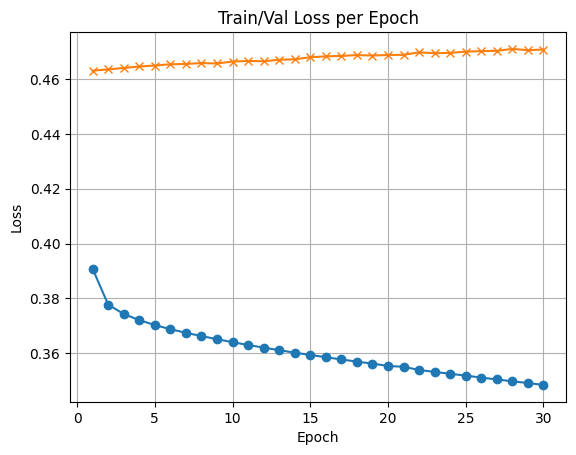

In [8]:
# 绘制loss曲线
print(train_loss_list)
print(val_loss_list)
plt.plot(range(1, num_epochs+1), train_loss_list, marker='o')
plt.plot(range(1, num_epochs+1), val_loss_list, marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Val Loss per Epoch')
plt.grid(True)
plt.show()

In [9]:
#验证
def get_val(model, val_loader, scaler_y, criterion): #在函数外计算loss
    model.eval()

    y_pred = []
    y_true = []
    SBP_pred_list = []
    DBP_pred_list = []
    SBP_ture_list = []
    DBP_ture_list = []

    SBP_errors = []
    DBP_errors = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            y_pred.append(outputs)
            y_true.append(targets)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)

    # 逆标准化
    y_pred = scaler_y.inverse_transform(y_pred.cpu().numpy()) 
    y_true = scaler_y.inverse_transform(y_true.cpu().numpy())


    SBP_pred_list = np.concatenate((SBP_pred_list, y_pred[:,0]), axis=0)
    SBP_ture_list= np.concatenate((SBP_ture_list, y_true[:,0]), axis=0)

    DBP_pred_list = np.concatenate((DBP_pred_list, y_pred[:,1]), axis=0)
    DBP_ture_list= np.concatenate((DBP_ture_list, y_true[:,1]), axis=0)

    # SBP_errors.append(mean_absolute_error(y_true[:][0], y_pred[:][0]))
    # DBP_errors.append(mean_absolute_error(y_true[:][1], y_pred[:][1]))
    # print(SBP_pred_list)
    SBP_errors=(mean_absolute_error(SBP_ture_list,SBP_pred_list))
    DBP_errors=(mean_absolute_error(DBP_ture_list, DBP_pred_list))
    # print('pred:', y_pred)
    # print('true:', y_true)
    # print('pred', SBP_pred_list, DBP_pred_list)
    # print('true', SBP_ture_list, DBP_ture_list)
    # print('SBP_error:', SBP_errors, 'DBP_error:', DBP_errors)
    val_loss = criterion(torch.tensor(y_pred), torch.tensor(y_true)).item()
    # return SBP_pred, DBP_pred, SBP_true, DBP_true
    return y_pred, y_true



SBP_pred_list = []
DBP_pred_list = []
SBP_ture_list = []
DBP_ture_list = []

SBP_errors = []
DBP_errors = []

y_pred, y_true = get_val(model, val_loader, scaler_y, criterion)


SBP_pred_list = np.concatenate((SBP_pred_list, y_pred[:,0]), axis=0)
SBP_ture_list= np.concatenate((SBP_ture_list, y_true[:,0]), axis=0)

DBP_pred_list = np.concatenate((DBP_pred_list, y_pred[:,1]), axis=0)
DBP_ture_list= np.concatenate((DBP_ture_list, y_true[:,1]), axis=0)

# SBP_errors.append(mean_absolute_error(y_true[:][0], y_pred[:][0]))
# DBP_errors.append(mean_absolute_error(y_true[:][1], y_pred[:][1]))
# print(SBP_pred_list)
SBP_errors=(mean_absolute_error(SBP_ture_list,SBP_pred_list))
DBP_errors=(mean_absolute_error(DBP_ture_list, DBP_pred_list))
# print('pred:', y_pred)
# print('true:', y_true)
# print('pred', SBP_pred_list, DBP_pred_list)
# print('true', SBP_ture_list, DBP_ture_list)
print('SBP_error:', SBP_errors, 'DBP_error:', DBP_errors)


SBP_error: 9.720839381242113 DBP_error: 6.470563205952823


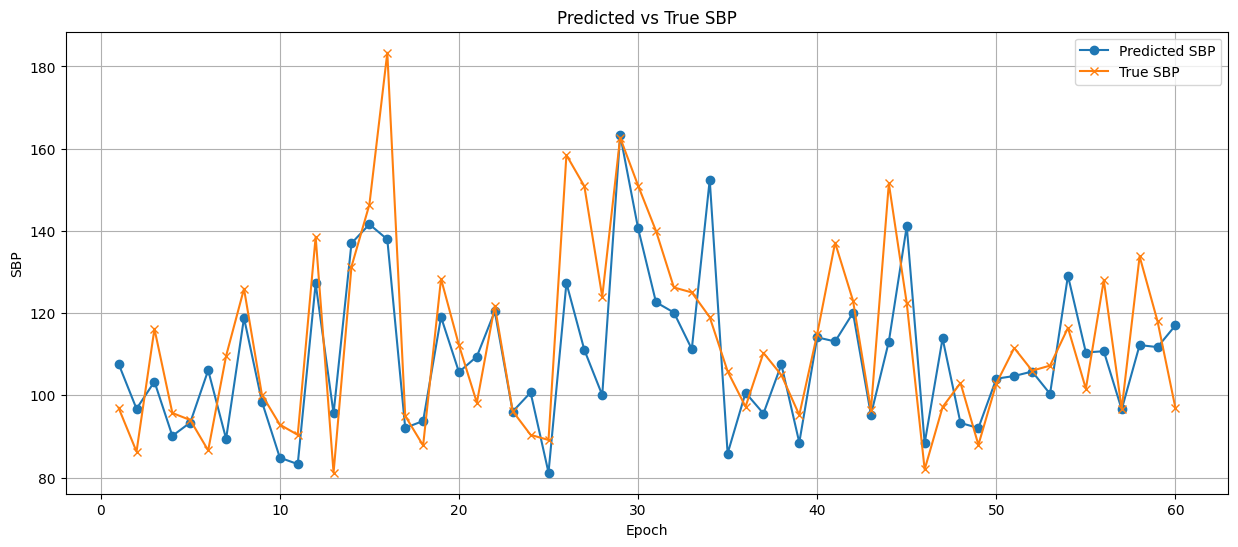

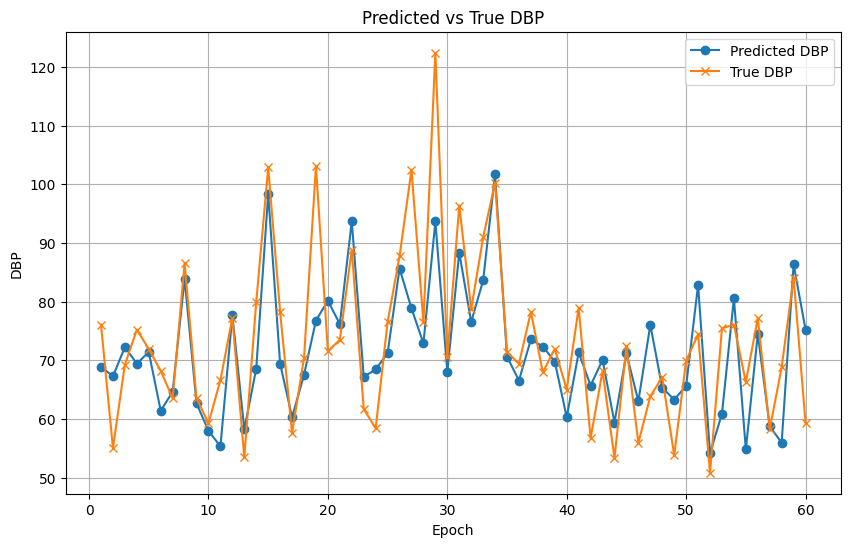

In [10]:
import random
K = random.randint(1, 9182)
# 创建折线图
x = SBP_pred_list[K:K+60]
y = SBP_ture_list[K:K+60]
# print(x)

epochs = np.arange(1, len(x) + 1)
plt.figure(figsize=(15, 6))
plt.plot(epochs, x, label='Predicted SBP', marker='o')
plt.plot(epochs, y, label='True SBP', marker='x')
plt.title('Predicted vs True SBP')
plt.xlabel('Epoch')
plt.ylabel('SBP')
plt.legend()
plt.grid(True)
plt.show()


x = DBP_pred_list[K:K+60]
y = DBP_ture_list[K:K+60]
# print(x)

epochs = np.arange(1, len(x) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, x, label='Predicted DBP', marker='o')
plt.plot(epochs, y, label='True DBP', marker='x')
plt.title('Predicted vs True DBP')
plt.xlabel('Epoch')
plt.ylabel('DBP')
plt.legend()
plt.grid(True)
plt.show()
